# Bi-LSTM model on Gossip data set 

The first model would be only for the title column with a binary target Fake/Not Fake.
This  Bi-LSTM model was built on the first LSTM Model (that was done by Andrii Shchur in 2020. Here is its [article](https://towardsdatascience.com/fake-news-detector-with-deep-learning-approach-part-i-eda-757f5c052)

Complete dataset cannot be distributed because of Twitter privacy policies and news publisher copy rights. Social engagements and user information are not disclosed because of Twitter Policy.  

The minimalistic version of latest dataset provided in this repo (located in dataset folder) include following files:
gossipcop_fake.csv - Samples related to fake news collected from GossipCop
gossipcop_real.csv - Samples related to real news collected from GossipCop
Each of the above CSV files is comma separated file and have the following columns

id - Unique identifider for each news
url - Url of the article from web that published that news
title - Title of the news article
tweet_ids - Tweet ids of tweets sharing the news. This field is list of tweet ids separated by tab.

<img src='https://media.giphy.com/media/l0Iyau7QcKtKUYIda/giphy.gif'>

### <span style="background-color: #FFFF00">In this notebook, I have corrected the preprocessing of the data</span>

## Importing packages 

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import os.path as op
import time
import matplotlib.pyplot as plt
#Loading keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
#Loading nltk
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#Loading sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
#Loading K-folds
from sklearn.model_selection import StratifiedKFold
#Loading the model 
import sys  
sys.path.insert(0, '../../models')
from PY.model4 import get_model

Using TensorFlow backend.


## Paths 

In [2]:
DATA_DIR = '../../../../Data'
CODE_DIR_H5='../../models/H5'
# Create a path for the saving location of the model
MODEL_DIR_H5 = CODE_DIR_H5 + '/model4_Gossip.h5'

## Loading Data 

In [3]:
# Load train data
train = pd.read_csv(op.join(DATA_DIR, 'Gossip/Claims_to_work_with/claims.csv'))
train 

title  label
0      Teen Mom Star Jenelle Evans' Wedding Dress Is ...      0
1      Kylie Jenner refusing to discuss Tyga on Life ...      0
2                                          Quinn Perkins      0
3      I Tried Kim Kardashian's Butt Workout & Am For...      0
4      Celine Dion donates concert proceeds to Vegas ...      0
...                                                  ...    ...
20738  'Battle of the Sexes' Premiere: Emma Stone on ...      1
20739   September 11: Celebrities Remember 9/11 (TWEETS)      1
20740  NASCAR owners threaten to fire drivers who pro...      1
20741  The 7 signs that David Beckham is definitely h...      1
20742  Jamie Foxx Spends the Day With Katie Holmes an...      1

[20743 rows x 2 columns]

In [4]:
# Find Na 
train.isnull().sum()

title    0
label    0
dtype: int64

In [5]:
#Get the Depndent feature
X_train=train.drop('label',axis=1)
y_train=train['label']

In [6]:
# set vocabulary size
vo_size=500
messages=X_train.copy()
messages.reset_index(inplace=True)

In [7]:
len(messages), len(y_train)

(20743, 20743)

In [8]:
# Dataset Preprocessing
cmp=0
ps =PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    review = re.sub('[^a-zA-Z]', ' ',messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    if review :
        review = ' '.join(review)
        corpus.append(review)
        y_train[i]=y_train[i]
    else :
        cmp=cmp+1
        y_train[i]=np.nan
y_train.reset_index()

Status: 19 / 20743

C:\Users\CBS Compter\anaconda3\envs\tensorflow7\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Status: 7274 / 20743

C:\Users\CBS Compter\anaconda3\envs\tensorflow7\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CBS Compter\anaconda3\envs\tensorflow7\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


index  label
0          0    0.0
1          1    0.0
2          2    0.0
3          3    0.0
4          4    0.0
...      ...    ...
20738  20738    1.0
20739  20739    1.0
20740  20740    1.0
20741  20741    1.0
20742  20742    1.0

[20743 rows x 2 columns]

In [9]:
print('the number of lines that could not be preprocessed',cmp)

the number of lines that could not be preprocessed 1


In [10]:
print("We need to delete those",y_train.isnull().sum(),"lines from the label column")
y_train=y_train.dropna()
y_train.astype('Int64')

We need to delete those 1 lines from the label column


0        0
1        0
2        0
3        0
4        0
        ..
20738    1
20739    1
20740    1
20741    1
20742    1
Name: label, Length: 20742, dtype: Int64

In [11]:
# one hot representation
onehot_rep = [one_hot(words, vo_size) for words in corpus]

In [12]:
# pad_sequences
sent_length = 20
embedded_doc=pad_sequences(onehot_rep, padding='pre', maxlen=sent_length)
print(embedded_doc)

[[  0   0   0 ... 429 362 117]
 [  0   0   0 ... 220 271 261]
 [  0   0   0 ...   0 112  51]
 ...
 [  0   0   0 ... 231 361 146]
 [  0   0   0 ... 384 354   2]
 [  0   0   0 ... 321 355 482]]


In [13]:
embedding_vector_feature = 10

In [14]:
# check shape 
len(embedded_doc),y_train.shape

(20742, (20742,))

In [15]:
# final data for NN
X_final=np.array(embedded_doc)
y_final=np.array(y_train)
X_final.shape,y_final.shape

((20742, 20), (20742,))

## Training  the model 

In [16]:
start=time.time()
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores1 = []
cvscores2 = []
cvscores3 = []
cvscores4 = []
num_iter=0

for train, test in kfold.split(X_final, y_final):
    num_iter=num_iter+1
    model=get_model(vo_size,embedding_vector_feature,sent_length)
    # Fit the model
    history=model.fit(X_final[train], y_final[train], epochs=10, batch_size=64,verbose=0)
    # evaluate the model
    scores = model.evaluate(X_final[test], y_final[test], verbose=0)
    print("------subset number", num_iter,"------")
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores1.append(scores[1] * 100)
    print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    cvscores2.append(scores[2] * 100)
    print("%s: %.2f%%" % (model.metrics_names[3], scores[3]*100))
    cvscores3.append(scores[3] * 100)
    print("%s: %.2f%%" % (model.metrics_names[4], scores[4]*100))
    cvscores4.append(scores[4] * 100)
print("--------------------------------------------" )   
print("accuracy","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores1), np.std(cvscores1)))
print("precision","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores2), np.std(cvscores2)))
print("recall","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores3), np.std(cvscores3)))
print("f1-mesure","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores4), np.std(cvscores4)))
end=time.time()

------subset number 1 ------
accuracy: 81.25%
precision_mesure: 23.69%
recall_mesure: 10.17%
f1_mesure: 13.75%
------subset number 2 ------
accuracy: 81.16%
precision_mesure: 24.62%
recall_mesure: 9.68%
f1_mesure: 13.73%
------subset number 3 ------
accuracy: 81.63%
precision_mesure: 23.33%
recall_mesure: 10.83%
f1_mesure: 14.50%
------subset number 4 ------
accuracy: 80.76%
precision_mesure: 23.38%
recall_mesure: 9.18%
f1_mesure: 12.80%
------subset number 5 ------
accuracy: 81.24%
precision_mesure: 23.85%
recall_mesure: 9.30%
f1_mesure: 12.97%
------subset number 6 ------
accuracy: 80.67%
precision_mesure: 23.46%
recall_mesure: 9.29%
f1_mesure: 13.01%
------subset number 7 ------
accuracy: 79.85%
precision_mesure: 23.85%
recall_mesure: 10.22%
f1_mesure: 14.06%
------subset number 8 ------
accuracy: 80.86%
precision_mesure: 24.62%
recall_mesure: 7.94%
f1_mesure: 11.87%
------subset number 9 ------
accuracy: 82.11%
precision_mesure: 23.46%
recall_mesure: 10.61%
f1_mesure: 14.47%
------

In [17]:
# Save the model
model.save(MODEL_DIR_H5)
model.summary() 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 20, 10)            5000      
_________________________________________________________________
bidirectional_9 (Bidirection (None, 200)               88800     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 201       
Total params: 94,001
Trainable params: 94,001
Non-trainable params: 0
_________________________________________________________________


In [18]:
print('time of training' , end-start)

time of training 1589.0687055587769


## Evaluation metrics

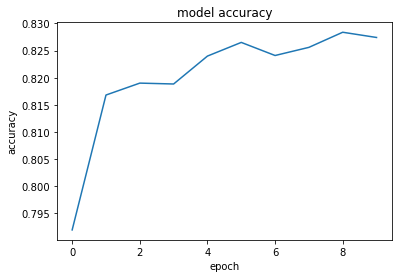

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

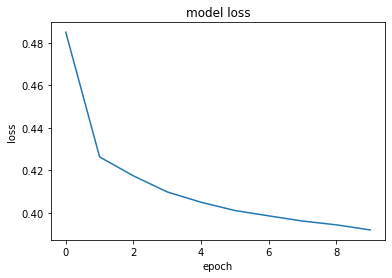

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

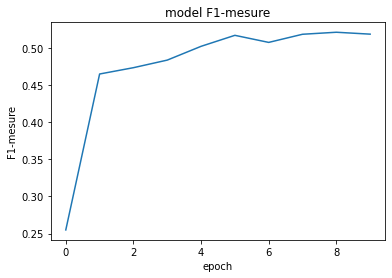

In [21]:
# summarize history for f1-mesure
plt.plot(history.history['f1_mesure'])
plt.title('model F1-mesure')
plt.ylabel('F1-mesure')
plt.xlabel('epoch')
plt.show()

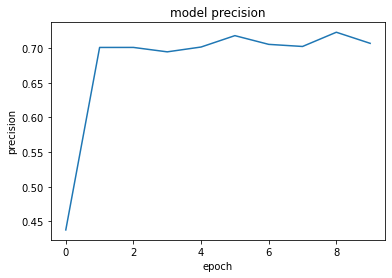

In [22]:
# summarize history for precision
plt.plot(history.history['precision_mesure'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.show()

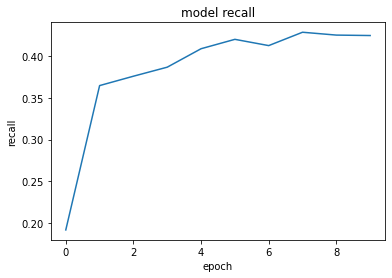

In [23]:
# summarize history for recall
plt.plot(history.history['recall_mesure'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.show()